In [163]:
import pymongo
import json
import csv

import numpy as np
import pandas as pd

#import seaborn as sns
#print(sns.__version__)
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

from utils import *
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
client = pymongo.MongoClient()
col = client['tweets']['december']

In [105]:
col.count()

1946408

In [75]:
col.find_one()

{'_id': ObjectId('5a25d095b13879ecbb114db6'),
 'contributors': None,
 'coordinates': None,
 'created_at': 'Mon Oct 30 14:18:08 +0000 2017',
 'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
 'favorite_count': 0,
 'favorited': False,
 'filter_level': 'low',
 'geo': None,
 'id': 925003891170832384,
 'id_str': '925003891170832384',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': {'attributes': {},
  'bounding_box': {'coordinates': [[[-83.694776, 41.580375],
     [-83.694776, 41.732806],
     [-83.454566, 41.732806],
     [-83.454566, 41.580375]]],
   'type': 'Polygon'},
  'country': 'United States',
  'country_code': 'US',
  'full_name': 'Toledo, OH',
  'id': '7068dd9474ab6973',
  'name': 'Toledo',
  'place_type': 'city',
  'url': 'https://api.twitter.com/1.1/geo/id/7068dd9474ab6973.json'},
 '

In [103]:
tweets_df = [{"created_at": item["created_at"],
              "text": item["text"].encode('unicode_escape'),
              "hashtags": ','.join([i['text'] for i in item['entities']['hashtags']]),
              "user": "@%s" % item["user"]["screen_name"],
              "placename": item['place']['full_name'],
              "province": item['place']['full_name'].split(', ')[-1],
              "city": item['place']['name'],
              "country": item['place']['country'],
              "source": item["source"] if item["source"] else '',
              "lang": item['lang'],              
              "latitude": item['geo']['coordinates'][0] if item['geo'] else np.nan,
              "longitude": item['geo']['coordinates'][1] if item['geo'] else np.nan
              
            } for item in col.find({"place.country": "Canada"})]
tweets_df = pd.DataFrame(tweets_df)
tweets_df.head()

,city,country,created_at,hashtags,lang,latitude,longitude,placename,province,source,text,user
0,Canada,Canada,Mon Oct 30 14:18:06 +0000 2017,,en,,,Canada,Canada,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",@Impeach_D_Trump Its Hillary with the microwav...,@Juebees99
1,Brampton,Canada,Mon Oct 30 14:17:46 +0000 2017,,en,,,"Brampton, Ontario",Ontario,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",kids that never listen.. always asking why..,@HrvyBrnt
2,Halifax,Canada,Mon Oct 30 14:17:54 +0000 2017,,en,,,"Halifax, Nova Scotia",Nova Scotia,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",@RaeGun2k She IS a big Harley Quinn fan,@sassypants81
3,Cornwall,Canada,Mon Oct 30 14:17:52 +0000 2017,,en,,,"Cornwall, Ontario",Ontario,"<a href=""http://twitter.com/download/iphone"" r...",This weather makes me wannang,@JessHoliday1
4,Toronto,Canada,Mon Oct 30 14:17:58 +0000 2017,,en,,,"Toronto, Ontario",Ontario,"<a href=""http://twitter.com/download/iphone"" r...",Steve was always one of my favourite character...,@trevorphiIlps


## Tweet language

In [119]:
print("Total # tweets:", len(tweets_df))
print("English tweets:", len(tweets_df.loc[tweets_df.lang == 'en']))
print("French tweets:", len(tweets_df.loc[tweets_df.lang == 'fr']))
print("Other language:", len(tweets_df.loc[(tweets_df.lang != 'en') & (tweets_df.lang != 'fr')]))

Total # tweets: 801955
English tweets: 669617
French tweets: 30541
Other language: 101797


In [169]:
print("Unique users:", tweets_df.user.unique().size)

Unique users: 99040


## Source client used by the user

Foursquare               3930
Tweetbot for Mac         3976
CUBE Live Feed App       7784
Tweetbot for iΟS         9677
Twitter for iPad        14735
TweetMyJOBS             21943
Instagram               70724
Twitter Web Client     104115
Twitter for Android    181203
Twitter for iPhone     355139
Name: source, dtype: int64

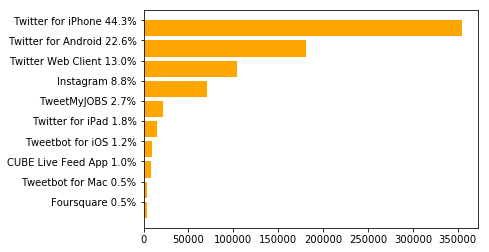

In [126]:
def get_source_name(x):
    value = re.findall(pattern="<[^>]+>([^<]+)</a>", string=x)
    if len(value) > 0:
        return value[0]
    else:
        return ""

tweets_df.source_name = tweets_df.source.apply(get_source_name)

source_counts = tweets_df.source_name.value_counts().sort_values()[-10:]

bottom = [index for index, item in enumerate(source_counts.index)]
plt.barh(bottom, width=source_counts, color="orange", linewidth=0)

y_labels = ["%s %.1f%%" % (item, 100.0*source_counts[item]/len(tweets_df)) for index,item in enumerate(source_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)
source_counts

## Tweets by region

In [161]:
regions_df = tweets_df.groupby(['placename']).apply(filter_tweets)
regions_df = regions_df.sort_values('num_tweets', ascending=False).head()

,latitude,longitude,num_tweets,physical_activity,sedentary_behavior,sleeping
placename,,,,,,
"Toronto, Ontario",43.684591,-79.384485,164696.0,18548.0,7721.0,3498.0
"Ottawa, Ontario",45.354133,-74.879702,43648.0,2924.0,2553.0,911.0
"Montréal, Québec",45.509251,-73.585675,41451.0,2863.0,1787.0,912.0
"Calgary, Alberta",51.040081,-114.070883,37644.0,2435.0,1861.0,873.0
"Vancouver, British Columbia",49.264337,-123.083918,37577.0,2604.0,1975.0,892.0


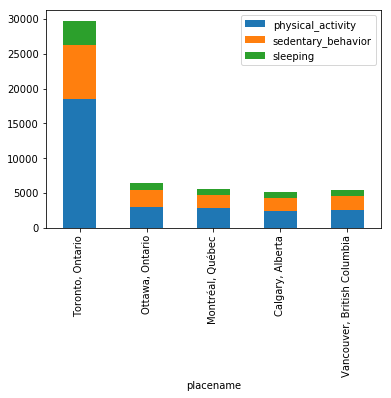

In [227]:
regions_df.ix[:10, ['physical_activity', 'sedentary_behavior', 'sleeping']].plot(kind='bar', stacked=True)

num_tweets            801955.0
physical_activity      62892.0
sedentary_behavior     39997.0
sleeping               17295.0
dtype: float64


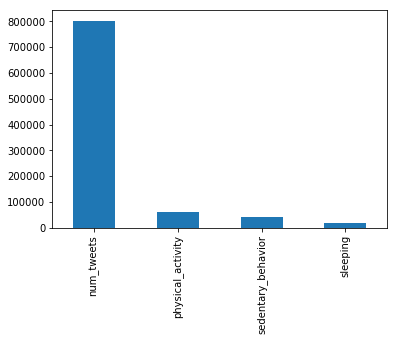

In [162]:
print(regions_df.loc[:, 'num_tweets':].sum())
regions_df.loc[:, 'num_tweets':].sum().plot(kind='bar')

## Checking the highest used words

In [164]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(tweets_df.text)

word_count = pd.DataFrame(cv.get_feature_names(), columns=["word"])
word_count["count"] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending=False).reset_index(drop=True)
word_count[:50]

,word,count
0,co,503010
1,https,501767
2,the,256008
3,to,194209
4,and,126752
5,in,118221
6,you,117685
7,for,112712
8,is,106088
9,of,105317
